In [1]:
# standard python utilities
import os
import sys
from os.path import basename, dirname, join, exists
import glob
import pandas as pd
import numpy as np
import time
from scipy.stats import gmean


# standard geospatial python utilities
# import pyproj # for converting proj4string
import shapely
import shapefile
import geopandas as gpd
from osgeo import gdal
import rasterio

# import flopy
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# statistics functions
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import datasets, linear_model
from scipy.stats import pearsonr, spearmanr, kendalltau


In [3]:
doc_dir = os.getcwd()
while os.path.basename(doc_dir) != 'Documents':
    doc_dir = os.path.dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = os.path.dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
# dir of stream level data for seepage study
proj_dir = gwfm_dir + '/Oneto_Denier/'
dat_dir = proj_dir+'Stream_level_data/'

sfr_dir = gwfm_dir+'/SFR_data/'

In [4]:
out_dir = join(proj_dir, 'output')
fig_dir = join(proj_dir, 'figures')

In [5]:
flopy_dir = doc_dir+'/GitHub/flopy'
if flopy_dir not in sys.path:
    sys.path.insert(0, flopy_dir)
    
import flopy 

In [6]:
ext_dir = 'F:/WRDAPP'
c_dir = 'C:/WRDAPP'
if os.path.exists(ext_dir):
    loadpth = ext_dir 
elif os.path.exists(c_dir):
    loadpth = c_dir 
loadpth +=  '/GWFlowModel/Cosumnes/Stream_seepage'

upscale = 4 # 8
upscale_txt = 'upscale'+str(upscale)+'x_'
# model_nam = 'inset_oneto_denier'
model_nam = 'oneto_denier_'+upscale_txt+'2014_2018'

base_model_ws = join(loadpth,model_nam)

# all_model_ws = join(loadpth, 'parallel_oneto_denier')
all_model_ws = join(loadpth, 'parallel_'+model_nam)

# may want to skip loading rch, evt and wel which take up a lot of memory with stress period data
load_only = ['DIS','UPW','SFR','OC']
m = flopy.modflow.Modflow.load('MF.nam', model_ws= base_model_ws, 
                                exe_name='mf-owhm.exe', version='mfnwt')


In [7]:
homogeneous_ws = join(loadpth, 'oneto_denier_homogeneous_2014_2018')


In [8]:
m_ver = ''

In [9]:
grid_dir = join(gwfm_dir, 'DIS_data/streambed_seepage/grid')
grid_fn = join(grid_dir, 'inset_oneto_denier','rm_only_grid.shp')
grid_p = gpd.read_file(grid_fn)
grid_p.crs='epsg:32610'
m_domain = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [grid_p.unary_union], crs=grid_p.crs)

In [10]:
XSg = pd.read_csv(join(base_model_ws,'04_XSg_filled.csv'))
XSg = gpd.GeoDataFrame(XSg, geometry = gpd.points_from_xy(XSg.Easting, XSg.Northing), crs='epsg:32610')

drop_iseg = XSg[~XSg['Logger Location'].isna()].iseg.values
# overwrite SFR segment/reach input relevant to seepage
# sensor_dict = pd.read_csv(join(model_ws, 'sensor_xs_dict.csv'), index_col=0)
# XS_params = sensor_dict.join(params.set_index('Sensor'), on='Sensor')

In [11]:
sfrdf = pd.DataFrame(m.sfr.reach_data)
grid_sfr = grid_p.set_index(['row','column']).loc[list(zip(sfrdf.i+1,sfrdf.j+1))].reset_index(drop=True)
grid_sfr = pd.concat((grid_sfr,sfrdf),axis=1)

# characterize streambed into different hydrofacies
tprogs_quants = np.array([0.590, 0.155, 0.197, 0.058]).cumsum()
vka_quants = grid_sfr.strhc1.quantile(tprogs_quants)
vka_quants.index=['mud','sandy mud','sand','gravel']
grid_sfr['facies'] = 'mud'
for n in np.arange(0,len(vka_quants)-1):
    grid_sfr.loc[grid_sfr.strhc1 > vka_quants.iloc[n],'facies'] = vka_quants.index[n+1]

# add color for facies plots
gel_color = pd.read_csv(join(gwfm_dir,'UPW_data', 'mf_geology_color_dict.csv'), comment='#')
gel_color.geology = gel_color.geology.str.lower()
grid_sfr = grid_sfr.join(gel_color.set_index('geology')[['color']], on='facies')
# remove stream segments for routing purposes only
grid_sfr = grid_sfr[~grid_sfr.iseg.isin(drop_iseg)]

In [12]:
strt_date = pd.to_datetime(m.dis.start_datetime)
end_date = (strt_date + pd.Series(m.dis.perlen.array.sum()).astype('timedelta64[D]'))[0]
# with SS period near 0 no longer minus one
dates_per = strt_date + (m.dis.perlen.array.cumsum()).astype('timedelta64[D]')
stplen = m.dis.perlen.array/m.dis.nstp.array
# astype timedelta64 results in save days
hrs_from_strt = ((np.append([0], np.repeat(stplen, m.dis.nstp.array)[:-1])).cumsum()*24).astype('timedelta64[h]')
dates_stps = strt_date + hrs_from_strt

# get ALL stress periods and time steps list, not just those in the output
kstpkper = []
for n,stps in enumerate(m.dis.nstp.array):
    kstpkper += list(zip(np.arange(0,stps),np.full(stps,n)))

dt_ref = pd.DataFrame(dates_stps, columns=['dt'])
dt_ref['kstpkper'] = kstpkper

# Obs checking

In [13]:
def nse(targets,predictions):
    return 1-(np.sum((targets-predictions)**2)/np.sum((targets-np.mean(predictions))**2))

# hob metadata
rm_grid = pd.read_csv(join(proj_dir, 'mw_hob_cleaned.csv'))


In [14]:
def clean_hob(model_ws):
    hobout = pd.read_csv(join(model_ws,'MF.hob.out'),delimiter=r'\s+', header = 0,names = ['sim_val','obs_val','obs_nam'],
                         dtype = {'sim_val':float,'obs_val':float,'obs_nam':object})
    hobout[['Sensor', 'spd']] = hobout.obs_nam.str.split('p',n=2, expand=True)
    hobout['kstpkper'] = list(zip(np.full(len(hobout),0), hobout.spd.astype(int)))
    hobout = hobout.join(dt_ref.set_index('kstpkper'), on='kstpkper')
    hobout['error'] = hobout.obs_val - hobout.sim_val
    hobout['sq_error'] = hobout.error**2
    return(hobout)

In [21]:
# 
sum_stats = pd.DataFrame(columns=['r2','RMSE','NSE'], dtype=np.float64)
mw_stats = pd.DataFrame(columns=['realization','SOSE','RMSE','NSE'], dtype=np.float64)
for t in np.arange(0,100):
    model_ws = join(all_model_ws, 'realization'+ str(t).zfill(3))
    hobout = clean_hob(model_ws)
    # removing oneto ag because of large depth offset
    hobout = hobout[hobout.Sensor != 'MW_OA']
    # summary stats by well
    mw_stats['realization'] = t
    for s in hobout.Sensor.unique():
        df_s = hobout[hobout.Sensor==s]
        mw_stats.loc[s,'SOSE'] = hobout[['Sensor','sq_error']].groupby('Sensor').sum()
        mw_stats.loc[s,'r2'] = r2_score(df_s.obs_val, df_s.sim_val)
        mw_stats.loc[s,'RMSE'] = mean_squared_error(df_s.obs_val, df_s.sim_val, squared=True)
        mw_stats.loc[s,'NSE'] = nse(df_s.obs_val, df_s.sim_val)

    # summary statistics
    sum_stats.loc[t,'r2'] = r2_score(hobout.obs_val, hobout.sim_val)
    sum_stats.loc[t,'RMSE'] = np.sqrt(hobout.sq_error.sum()/len(hobout))
    sum_stats.loc[t,'NSE'] = nse(hobout.obs_val, hobout.sim_val)


In [22]:
# filter out realizations who haven't finished running yet
stats_done = sum_stats[sum_stats.NSE!=sum_stats.NSE.min()].copy()

<Axes: >

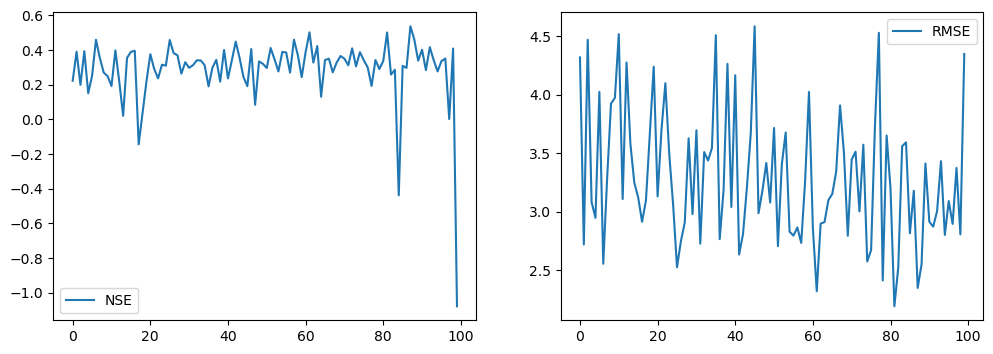

In [23]:
# review to see if error is generally similar between realizations
# review hydrographs for realization with worst error
fig,ax = plt.subplots(1,2, figsize=(12,4))
stats_done.plot(y='NSE', ax=ax[0])
stats_done.plot(y='RMSE', ax=ax[1])


In [229]:
# identify the 10 realizations with the best accuracy
# calculate best score, r2 is tiebreak
stats_done['score'] = (stats_done.NSE >= stats_done.NSE.quantile([0.9]).values[0]).astype(float)
stats_done.score += (stats_done.RMSE <= stats_done.RMSE.quantile([0.1]).values[0]).astype(float)
stats_done.score += (stats_done.r2 >= stats_done.r2.quantile([0.9]).values[0]).astype(float)*0.25
# pull 10 best realizations 
best_realizations = stats_done[stats_done.score >= stats_done.score.quantile([0.9]).values[0]]
print('best realizations', best_realizations.index)
best_realizations.to_csv(join(proj_dir,upscale_txt+'top_10_accurate_realizations.csv'))


best realizations Int64Index([25, 41, 42, 55, 74, 75, 78, 82, 88, 99], dtype='int64')


In [24]:
# check hydrographs with worst error
# t = sum_stats['RMSE'].idxmax()
t = sum_stats['RMSE'].idxmin()
# approximate median location
# t = sum_stats[1:][(sum_stats[1:].NSE == sum_stats[1:].NSE.median())].index[0]

# t = 45
print(t)
hobout = clean_hob(join(all_model_ws, 'realization'+ str(t).zfill(3)))
# removing oneto ag because of large depth offset
hobout = hobout[hobout.Sensor != 'MW_OA']
hob_long = hobout.melt(id_vars=['dt', 'Sensor'],value_vars=['sim_val','obs_val'], value_name='gwe')
# hob_long

81


In [25]:
# hob_long.dt

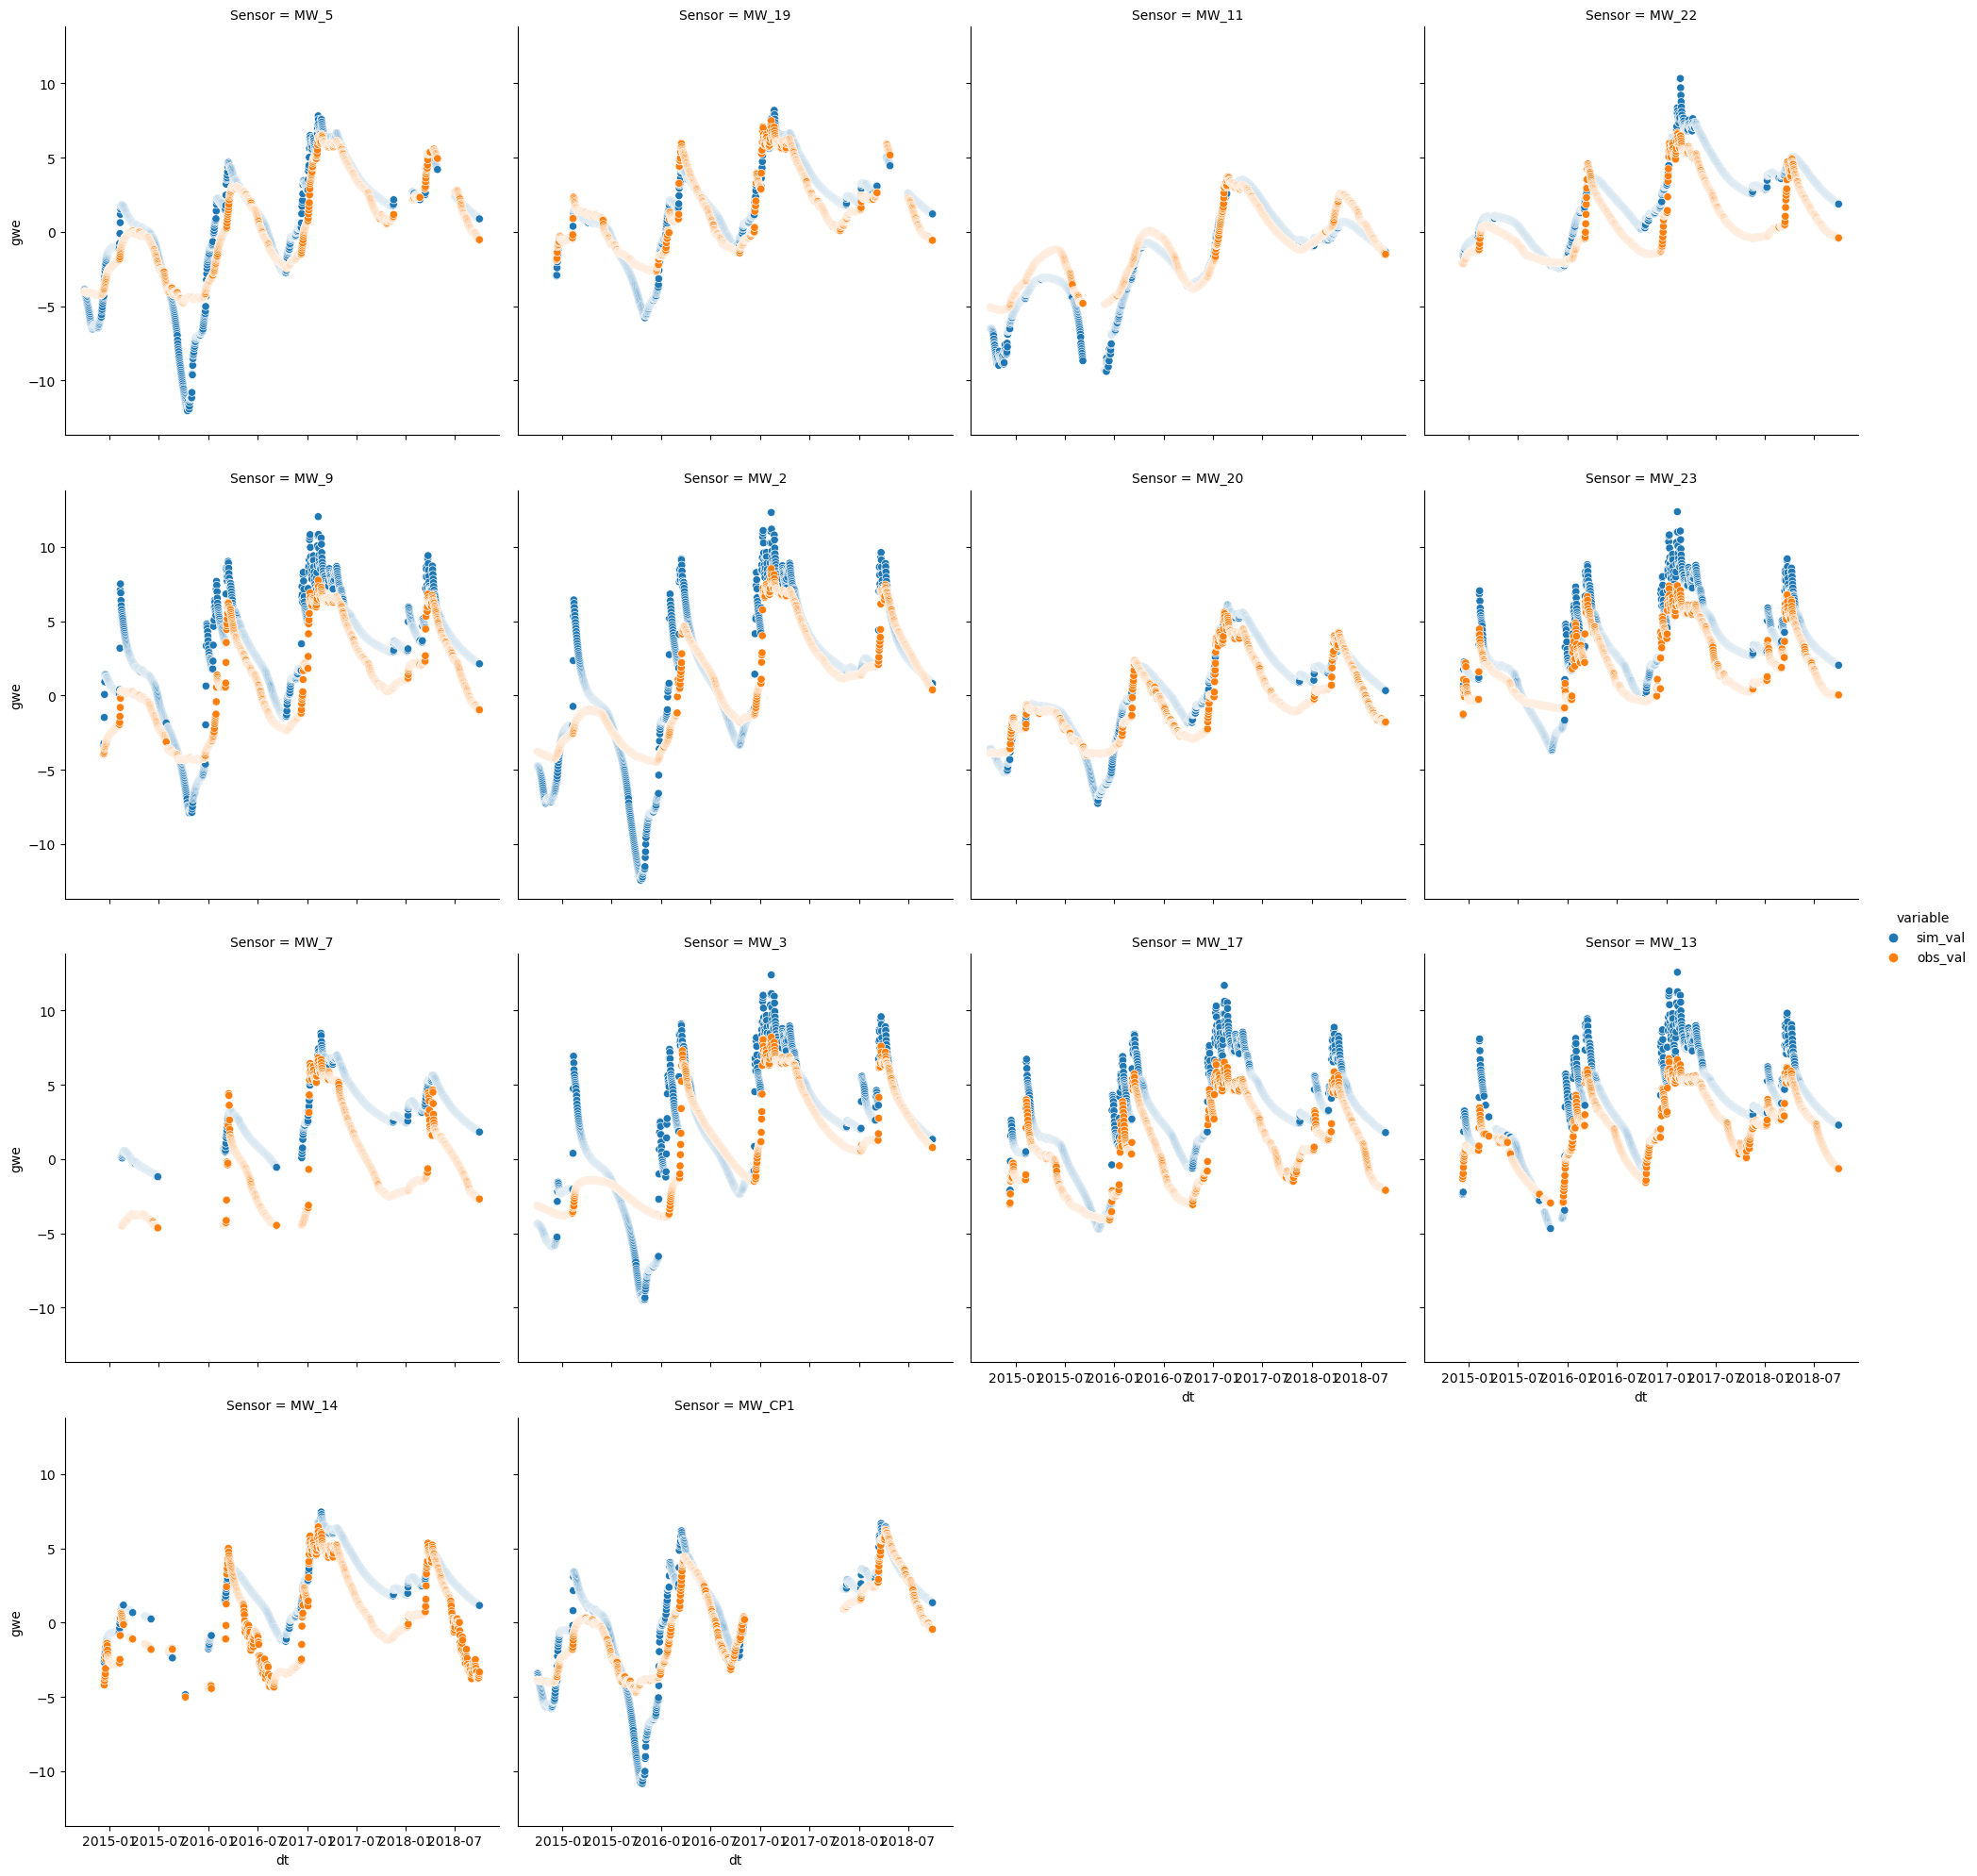

In [26]:
# in the wrost case the dynamics match but the magnitude is off (levels start much too low)
import seaborn as sns
g = sns.relplot(hob_long, x='dt',y='gwe',col='Sensor',hue='variable', col_wrap=4)



In [12]:
gage_cols = ['time','stage','volume','conc','inflows','outflows','conductance','error']

def read_gage(gagenam):
    gage = pd.read_csv(gagenam,skiprows=1, delimiter = r'\s+', engine='python')
    cols = gage.columns[1:-1]
    gage = gage.dropna(axis=1)
    gage.columns = cols
    strt_date = pd.to_datetime(m.dis.start_datetime)
    gage['dt'] = strt_date+(gage.Time*24).astype('timedelta64[h]')
    gage = gage.set_index('dt')
    gage['dVolume'] = gage.Volume.diff()
    gage['Total_In'] = gage[['Precip.','Runoff','GW-Inflw','SW-Inflw']].sum(axis=1)
    gage['Total_Out'] = gage[['Evap.','Withdrawal','GW-Outflw','SW-Outflw']].sum(axis=1)
    gage['In-Out'] = gage.Total_In - gage.Total_Out
#     gage['name'] = run
    return(gage)


## Water Budget check

In [27]:
# manual columns
wb_out_cols  =['WEL_OUT','ET_OUT','GHB_OUT','SFR_OUT','LAK_OUT']
wb_in_cols = ['RCH_IN','GHB_IN','SFR_IN','LAK_IN']

In [31]:
wb_all = pd.DataFrame()
for t in np.arange(0,100):
    model_ws = join(all_model_ws, 'realization'+ str(t).zfill(3))
    # load summary water budget
    wb = pd.read_csv(model_ws+'/flow_budget.txt', delimiter=r'\s+')
    # wb = pd.read_csv(loadpth+'/oneto_denier_upscale8x_2014_2018'+'/flow_budget.txt', delimiter=r'\s+')
    wb['kstpkper'] = list(zip(wb.STP-1,wb.PER-1))
    wb = wb.merge(dt_ref, on='kstpkper')
    wb['realization'] = t
    wb_all = pd.concat((wb_all, wb))


In [64]:
# wb_plt.mean(axis=1)
# need to update homogeneous run for layering and
wb_h = pd.read_csv(homogeneous_ws+'/flow_budget.txt', delimiter=r'\s+')
wb_h['kstpkper'] = list(zip(wb_h.STP-1,wb_h.PER-1))
wb_h = wb_h.merge(dt_ref, on='kstpkper')

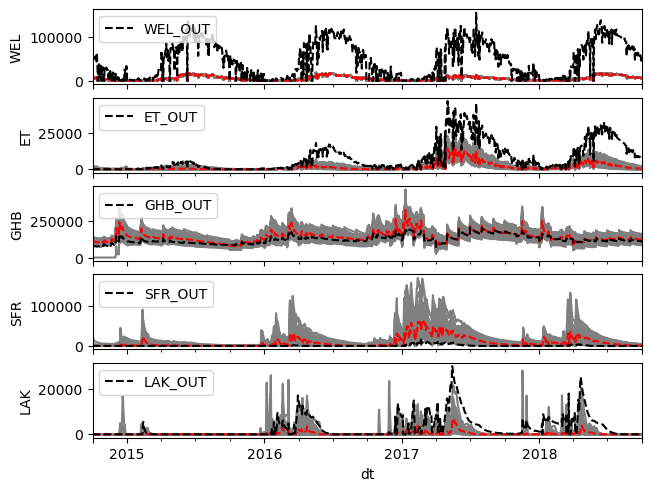

In [65]:
fig,ax = plt.subplots(5,1, sharex=True, layout='constrained')
for n, wb_n in enumerate(wb_out_cols):
    wb_plt = wb_all.pivot_table(index='dt',columns='realization',values=wb_n)
    wb_plt.plot(legend=False, color='gray', ax=ax[n]) 
    wb_plt.mean(axis=1).plot(color='red',linestyle='--',ax=ax[n])
    wb_h.plot(x='dt', y=wb_out_cols[n], color='black',linestyle='--',ax=ax[n])
    ax[n].set_ylabel(wb_out_cols[n].split('_')[0])

# Stream seepage plots

In [322]:
# pd_sfr = grid_sfr.set_index(['iseg','ireach'])[['rchlen','strtop', 'facies', 'color']]
# pd_sfr['Total distance (m)'] = pd_sfr['rchlen'].cumsum()

def clean_sfr_df(model_ws, drop_iseg):
    ## load sfr reach data ##
    grid_sfr = pd.read_csv(model_ws+'/grid_sfr.csv')
    # remove stream segments for routing purposes only
    grid_sfr = grid_sfr[~grid_sfr.iseg.isin(drop_iseg)]
    pd_sfr = grid_sfr.set_index(['iseg','ireach'])[['rchlen','strtop', 'facies', 'color']]
    pd_sfr['Total distance (m)'] = pd_sfr['rchlen'].cumsum()
    num_coarse = int(grid_sfr.facies.isin(['Gravel','Sand']).sum())
    
    ## load sfr out file ##
    sfrout = flopy.utils.SfrFile(join(model_ws, m.name+m_ver+'.sfr.out'))
    sfrdf = sfrout.get_dataframe()
    sfrdf = sfrdf.join(dt_ref.set_index('kstpkper'), on='kstpkper').set_index('dt')
    # convert from sub-daily to daily using mean, lose kstpkper
    sfrdf = sfrdf.groupby('segment').resample('D').mean(numeric_only=True)
    sfrdf = sfrdf.reset_index('segment', drop=True)
    sfrdf[['row','column']] = sfrdf[['row','column']].astype(int) - 1 # convert to python
    
    ## join sfr out to reach data ##
    sfrdf = sfrdf.join(pd_sfr ,on=['segment','reach'],how='inner',lsuffix='_all')
    sfrdf['num_coarse'] = num_coarse
    
    ## data transformation for easier manipulation ##
    sfrdf['month'] = sfrdf.index.month
    sfrdf['WY'] = sfrdf.index.year
    sfrdf.loc[sfrdf.month>=10, 'WY'] +=1
    # create column to calculate days flowing
    sfrdf['flowing'] = 1
    sfrdf.loc[sfrdf.Qout <= 0, 'flowing'] = 0
    
    # create different column for stream losing vs gaining seeapge
    sfrdf['Qrech'] = np.where(sfrdf.Qaquifer>0, sfrdf.Qaquifer,0)
    sfrdf['Qbase'] = np.where(sfrdf.Qaquifer<0, sfrdf.Qaquifer*-1,0 )
    # booleans for plotting
    sfrdf['gaining'] = (sfrdf.gradient <= 0)
    sfrdf['losing'] = (sfrdf.gradient >= 0)
    sfrdf['connected'] = (sfrdf.gradient < 1)
    return(sfrdf)



In [325]:
sfrdf =  clean_sfr_df(base_model_ws, drop_iseg)
h_sfrdf =  clean_sfr_df(homogeneous_ws, drop_iseg)


In [423]:
# standardize grouping values
wy_vals = sfrdf.WY.unique()
facies_vals = ['Mud','Sandy Mud','Sand','Gravel']


# Aggregate stream data
1. Aggregate across all segments  but save all dates
2. Aggregate across dates but save all segments


## Gradient plots (spatial)
1. Seepage averaged across the year (or between dry and wet season) and the rows could be realizations instead which would help indicate consistency across realizations  
2. Heat map of columns with stream segments, rows of dates and the color blue to red for gaining or losing with the seepage averaged across all realizations

When the gradient is greater than 1 we know we have disconnected conditions, I need to represent the count of days where the system is connected.

In [326]:
# aggregate data by facies and sum to review seepage over time
t0 = time.time()

sfr_facies_all = pd.DataFrame()
for t in np.arange(0,100):
    model_ws = join(all_model_ws, 'realization'+ str(t).zfill(3))
    # remove stream segments for routing purposes
    sfrdf =  clean_sfr_df(model_ws, drop_iseg)
    # summing by facies makes sense for seepage
    sfr_facies_sum = sfrdf.groupby(['dt','facies']).sum(numeric_only=True)
    sfr_facies_sum['realization'] = t
    # count number of facies if needed later for explaining rates
    sfr_facies_sum['num_facies'] = sfrdf.groupby(['dt','facies']).count().iloc[:,0].values
    sfr_facies_all = pd.concat((sfr_facies_all, sfr_facies_sum))
# check time
t1 = time.time()
print('Time: %.2f min' % ((t1-t0)/60))
# save output to speed up reuse
# sfr_facies_all.to_csv(join(out_dir, 'sfrdf_facies_sum.csv'))
sfr_facies_all.reset_index(level='facies').to_hdf(join(out_dir, 'sfrdf_facies_sum.hdf5'), key='dt', complevel=4)

Time: 6.56 min


In [327]:
sfr_facies_all = pd.read_hdf(join(out_dir, 'sfrdf_facies_sum.hdf5'))
# sfr_facies_all = sfr_facies_all.set_index('facies', append=True)

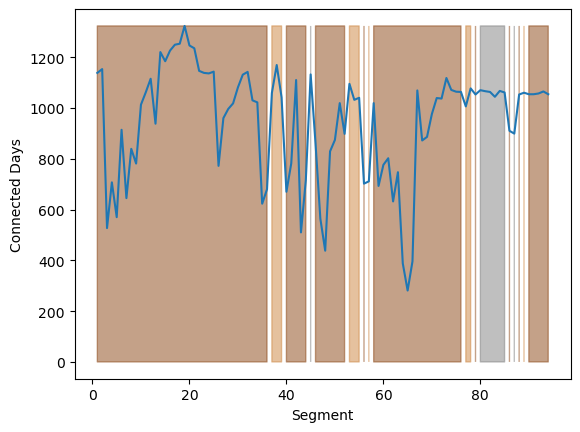

In [335]:
# fig,ax = plt.subplots()

# days connected
df_plt = sfrdf.groupby('segment').sum(numeric_only=True)[['connected']]
ax_conn = df_plt.plot(legend=False)
plt.ylabel('Connected Days')
plt.xlabel('Segment')

for f in sfrdf.facies.unique():
    ax_conn.fill_between(sfrdf.segment, 0, df_plt.max(), where = sfrdf.facies==f,
                    color=gel_color.loc[gel_color.geology==f,'color'], alpha=0.5)

## Notes
In these I need to clarify the proportion of the streambed (length or area) that is each facies to show that despite being only a small percent of the streambed sand and gravel make up a significant portion of recharge and baseflow. 

## Seepage plots (temporal)
Aggregate by facies to plot cumulative seepage (by time) to help show variability caused by geology.

In [35]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color='gray', label='Heterogeneous\nRealizations'),
    Line2D([0], [0], color='black', linestyle='--',label='Homogeneous\nCase'),
    Line2D([0], [0], color='red', linestyle='--', label='Heterogeneous\nMean')
]


Despite being only a small percentage of the stream segments, the sand and gravel produce a significant portion of the stream seepage.

In [254]:
value = 'Qbase'
ylabel  = 'Baseflow ($m^3/d$)'
def plt_dt_facies(value, ylabel):
    # original plotting was 12 by8 but then text is very small
    fig,ax = plt.subplots(2,2, figsize=(8,5.3), sharex=True, sharey=True, layout='constrained')#
    facies = ['Mud','Sandy Mud','Sand','Gravel']
    for t in np.arange(0,100):
        sfr_facies_sum = sfr_facies_all[sfr_facies_all.realization==t]
        for n,f in enumerate(facies):
            ax_n = ax[int(n/2), n%2]
            df_plt = sfr_facies_sum[sfr_facies_sum.facies==f]
            if df_plt.shape[0]>0:
                df_plt.plot(y=value, ax=ax_n, legend=False, color='gray')
    # plot homogeneous case
    h_sfr_facies_sum = h_sfrdf.groupby(['dt','facies']).sum(numeric_only=True)
    # plot mean of heterogeneous
#     sfr_facies_mean = sfr_facies_all.groupby(['dt', 'facies','realization']).sum(numeric_only=True)
    sfr_facies_mean = sfr_facies_all.groupby(['dt', 'facies']).mean().reset_index('facies')
    # set axis labels
    for n,f in enumerate(facies):
        ax_n = ax[int(n/2), n%2]
        h_sfr_facies_sum.reset_index('facies').plot(y=value, ax=ax_n, legend=False, color='black', linestyle='--')
        sfr_facies_mean[sfr_facies_mean.facies==f].plot(y=value, ax=ax_n, legend=False, color='red', linestyle='--')
        ax_n.set_title(f)
        ax_n.set_yscale('log')
        ax_n.set_ylabel(ylabel)
        ax_n.set_xlabel('Date')
    # add figure legend
    fig.legend(handles=legend_elements, loc='outside upper center', ncol = 3)


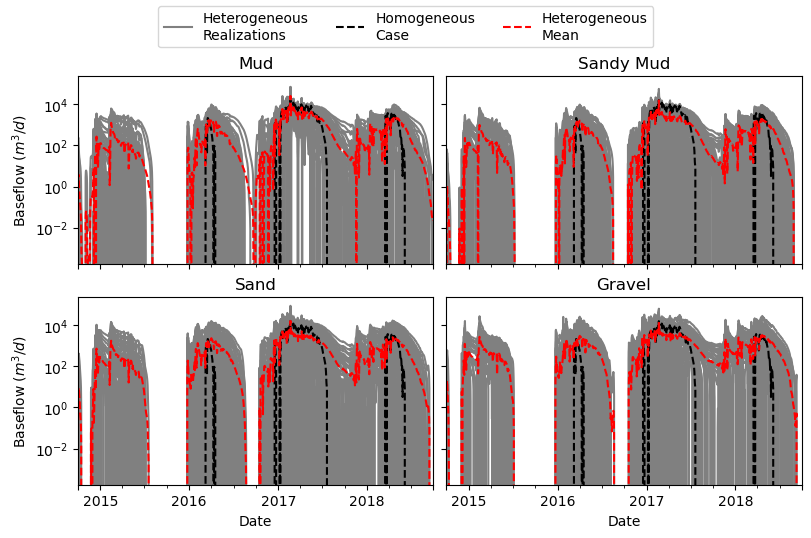

In [258]:
value = 'Qbase'
plt_dt_facies(value, ylabel)
# ax.legend(handles=legend_elements, loc='lower right')


In [238]:
# value = 'Qrech'
# ylabel  = 'Stream Seepage ($m^3/d$)'
# plt_dt_facies(value, ylabel)


In [891]:
# is it worth plotting the change in groundwater storage when there isn't a clear area to track
# I could assume a buffer distance of 1000 m but that may not be enough or could be too much
sfrdf.columns

Index(['layer', 'row', 'column', 'segment', 'reach', 'Qin', 'Qaquifer', 'Qout',
       'Qovr', 'Qprecip', 'Qet', 'stage', 'depth', 'width', 'Cond', 'gradient',
       'strtop_all', 'k', 'i', 'j', 'rchlen', 'strtop', 'facies', 'color',
       'Total distance (m)', 'num_coarse', 'month', 'WY', 'flowing', 'Qrech',
       'Qbase', 'gaining', 'losing', 'connected', 'realization'],
      dtype='object')

## Streamflow
No need to aggregate by facies, instead show impact at downstream end in terms of time step and cumulative

In [285]:
sfr_last_all = pd.DataFrame()
for t in np.arange(0,100):
    model_ws = join(all_model_ws, 'realization'+ str(t).zfill(3))
    sfrdf =  clean_sfr_df(model_ws, drop_iseg)
    # plot from last segment (shows cumulative effects)
    sfr_last = sfrdf[sfrdf.segment==sfrdf.segment.max()].copy()
    sfr_last['realization'] = t
    sfr_last_all = pd.concat((sfr_last_all, sfr_last))

# save data
sfr_last_all.to_hdf(join(out_dir, 'sfrdf_last_seg.hdf5'), key='dt', complevel=4)

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_100216\78463392.py:11: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['facies', 'color'], dtype='object')]

  sfr_last_all.to_hdf(join(out_dir, 'sfrdf_last_seg.hdf5'), key='dt', complevel=4)


In [286]:
sfr_last_all = pd.read_hdf(join(out_dir, 'sfrdf_last_seg.hdf5'))

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_100216\3177288223.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sfr_last_mean = sfr_last_all.groupby('dt').mean()


Time: 0.10 min


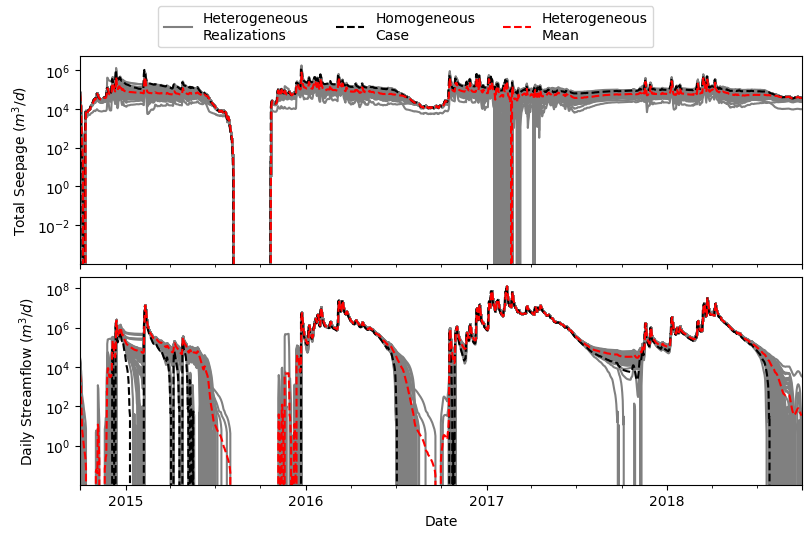

In [265]:
t0 = time.time()
fig,ax = plt.subplots(2,1, figsize=(8,5.3), sharex=True, sharey=False, layout='constrained',)

for t in np.arange(0,100):
    sfr_last = sfr_last_all[sfr_last_all.realization==t]
    sfr_last.plot(y='Qin', ax=ax[1], legend=False, color='gray')
    sfr_seg = sfr_facies_all[sfr_facies_all.realization==t].groupby('dt').sum(numeric_only=True)
    sfr_seg.plot(y='Qaquifer', ax=ax[0], legend=False, color='gray')

# plot homogeneous case
h_sfr_last = h_sfrdf[h_sfrdf.segment==h_sfrdf.segment.max()]
h_sfr_last.plot(y='Qin', ax=ax[1], legend=False, color='black',linestyle='--')
h_sfrdf.groupby('dt').sum(numeric_only=True).plot(y='Qaquifer', ax=ax[0], legend=False, color='black', linestyle='--')
# plot mean of heterogeneous
sfr_last_mean = sfr_last_all.groupby('dt').mean()
sfr_last_mean.plot(y='Qin', ax=ax[1], legend=False, color='red',linestyle='--')
sfr_sum_mean = sfr_facies_all.groupby(['dt', 'realization']).sum(numeric_only=True).groupby('dt').mean()
sfr_sum_mean.plot(y='Qaquifer', ax=ax[0], legend=False, color='red', linestyle='--')

# set axis labels
ax[1].set_ylabel('Daily Streamflow ($m^3/d$)')
ax[1].set_xlabel('Date')
ax[1].set_yscale('log')
ax[0].set_ylabel('Total Seepage ($m^3/d$)')
# need log scale or peaks wash out other data
ax[0].set_yscale('log')
fig.legend(handles=legend_elements, loc='outside upper center', ncol = 3)

# fig.tight_layout()

t1 = time.time()
print('Time: %.2f min' % ((t1-t0)/60))


## Scatter plots
**Goal**: relate the heterogeneity (e.g., number of coarse bodies connecting to the stream) to the number of days with streamflow.

Need to save data as an aggregated dataframe to run trend analysis

In [328]:
t0 = time.time()

sfr_3mon_all = pd.DataFrame()
sfr_yr_sum_all = pd.DataFrame()

for t in np.arange(0,100):
    model_ws = join(all_model_ws, 'realization'+ str(t).zfill(3))
    # clean sfr output
    sfrdf =  clean_sfr_df(model_ws, drop_iseg)
    sfrdf['realization'] = t
    num_coarse = sfrdf['num_coarse'].mean()
    # aggregate to seasonal values, since model starts in october it groups as oct-dec, jan-mar, apr-jun, jul-sep
    sfrdf_mon = sfrdf.resample('3MS').mean(numeric_only=True)
    sfrdf_mon['realization'] = t
    sfrdf_mon['num_coarse'] = num_coarse
    sfr_3mon_all = pd.concat((sfr_3mon_all, sfrdf_mon))
    # aggregate to annual values for each segment
    sfrdf_yr_sum = sfrdf.groupby(['WY','segment']).sum(numeric_only=True)
    sfrdf_yr_sum['realization'] = t
    sfrdf_yr_sum['num_coarse'] = num_coarse
    sfr_yr_sum_all = pd.concat((sfr_yr_sum_all, sfrdf_yr_sum))
# check time
t1 = time.time()
print('Time: %.2f min' % ((t1-t0)/60))

# save output to speed up reuse
sfr_3mon_all.to_csv(join(out_dir, 'sfrdf_3month_mean.csv'))
sfr_yr_sum_all.to_csv(join(out_dir, 'sfrdf_annual_sum_by_segment.csv'))

Time: 6.65 min


In [329]:
# load previously made output to speed up reuse
sfr_3mon_all = pd.read_csv(join(out_dir, 'sfrdf_3month_mean.csv'), parse_dates=['dt'], index_col='dt')
# fix issue where this was averaged
sfr_3mon_all.month = sfr_3mon_all.index.month
sfr_yr_sum_all = pd.read_csv(join(out_dir, 'sfrdf_annual_sum_by_segment.csv'), index_col=['WY','segment'])

In [330]:
# after resampling if need to re-identify the number of coarse in a stream
coarse_ref = sfr_3mon_all.groupby('realization').mean(numeric_only=True)[['num_coarse']]

In [56]:
# sfr_seg_all = pd.DataFrame()
# for t in np.arange(0,100):
#     ## plot the connected days ##
#     sfr_seg = sfrdf.groupby('segment').sum(numeric_only=True)[['connected']]
#     sfr_seg_all = pd.concat((sfr_seg_all, sfr_seg))

In [268]:

def plt_wy_seg(value, ylabel):
    fig,ax = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey=True, layout='constrained')
    wy_unique = sfr_yr_sum_all.index.get_level_values('WY').unique()

    for t in np.arange(0,100):
        sfr_yr_sum = sfr_yr_sum_all[sfr_yr_sum_all.realization==t].reset_index('WY')
        for n,f in enumerate(wy_unique):
            ax_n = ax[int(n/2), n%2]
            df_plt = sfr_yr_sum[sfr_yr_sum.WY==f]
            if df_plt.shape[0]>0:
                df_plt.plot(y=value, ax=ax_n, legend=False, color='gray')

    # plot homogeneous case
    h_sfr_yr_sum = h_sfrdf.groupby(['WY', 'segment']).sum(numeric_only=True).reset_index('WY')
    # plot mean of heterogeneous
    sfr_yr_sum_mean = sfr_yr_sum_all.groupby(['WY','segment']).mean().reset_index('WY')
    # set axis labels
    for n,f in enumerate(wy_unique):
        ax_n = ax[int(n/2), n%2]
        h_sfr_yr_sum[h_sfr_yr_sum.WY==f].plot(y=value, ax=ax_n, legend=False, color='black', linestyle='--')
        sfr_yr_sum_mean[sfr_yr_sum_mean.WY==f].plot(y=value, ax=ax_n, legend=False, color='red', linestyle='--')
        ax_n.set_title(f)
        ax_n.set_ylabel(ylabel)
        ax_n.set_xlabel('Segment')
    #     ax_n.set_yscale('log')
#     fig.tight_layout()
#     fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=[0.55, 1.03], ncol = 3)
    fig.legend(handles=legend_elements, loc='outside upper center', ncol = 3)


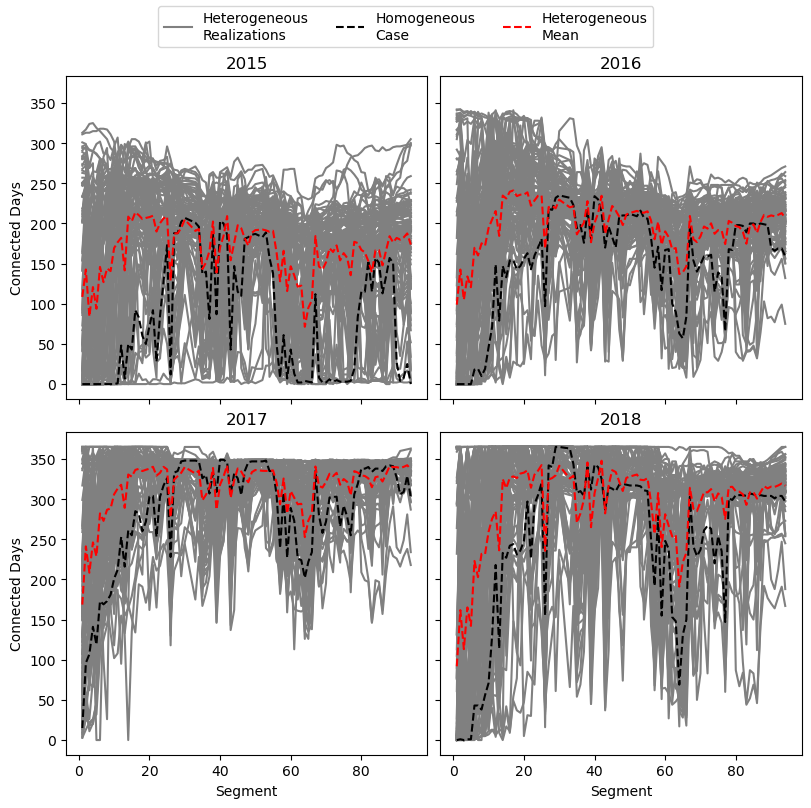

In [143]:
value = 'connected'
ylabel = 'Connected Days'
plt_wy_seg(value, ylabel)
# ax.legend(handles=legend_elements, loc='lower right')


The days with flow drops off at segment 31 because half of the flow becomes over bank flow to the floodplain so less water remains in the channel to recharge near the channel.

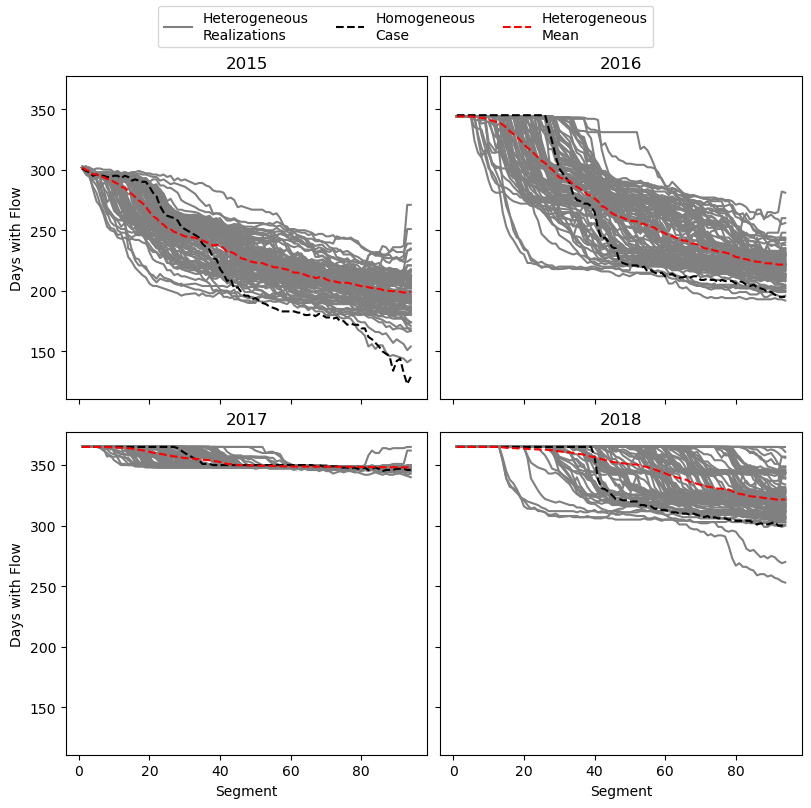

In [269]:
value = 'flowing'
ylabel = 'Days with Flow'
plt_wy_seg(value, ylabel)

In [81]:
# need to see why water could be leaving the lake in a few scenarios
# g = sns.relplot(sfr_yr_sum_all, x='segment',y='flowing', col='WY', col_wrap=2, hue='realization', #color='gray', 
#            facet_kws={'sharey': False, 'sharex': True})



In [470]:
# import seaborn as sns

# g = sns.relplot(sfrdf_all, x='num_coarse',y='Qbase', col= 'month', row='WY', color='gray', 
#            facet_kws={'sharey': False, 'sharex': True})



# Statistics
1. Present overview of all parts of the streamflow system that could be reasonably impacted by heterogeneity, streamflow, streambed recharge, stream baseflow, days with flow, stream-aquifer connectivity and maybe gradient. Present on aggregate basis or annual basis with just the correlation values.  

2. Present the streamflow components with high correlation values on a seasonal and annual basis to show how heterogeneity plays a larger role at different times of the year.

- For streamflow the annual sum or mean should only be taken on the last segment to look at cumulative effects.
- For streambed recharge and baseflow the annual sum across all segments should be used with either the sum or mean across all days.
- For stream-aquifer connectivity it would need to be the mean across all segments and the sum across all days. The gaining losing relationship is equal and opposite so only use gaining.

Is it worth looking at how the correlation is on a daily scale?

- Pearson's r absolute value: .5 to 1 is strong, .3 to .5 is moderate, 0 to .3 is weak
    - italicize r, no leading zero as maximum is 1, two significant digits is common, if reporting significance of the test then also report degrees of freedom (sample size - 2)   
- Spearman's coefficient is defined as the Pearson coefficient between the rank variables. X, Y are converted to ranks R(X), R(Y) then pearson's r is calculated.
- Kendall's tau is a test on whether the order of the variables aligns with the values, that is xi > xj and yi > yj to be considered concordant. The statistics then is based on the number of concordant and discordant pairs.

In [547]:
variables = {'Qbase':'Baseflow','Qrech':'Recharge', 'flowing':'Flowing',
             'connected':'Connected', 'gaining':'Gaining',
            'Qout':'Streamflow'}
tests = ['Pearson','Spearman','Kendall']

## Correlations for all time

In [690]:
# the data is already summed across the year and should be averaged across segments
corr_bool = sfr_yr_sum_all.groupby(['realization', 'segment']).sum().groupby('realization').mean()
corr_bool = corr_bool[['flowing','connected','gaining']]
# seepage data just needs to be summed again 
corr_seep = sfr_yr_sum_all.groupby('realization').sum(numeric_only=True)[['Qbase','Qrech']]
# flow data should be averaged
# i tried log10 transform but was problematic with zeros and replacement value, also had lower correlation
corr_flow = sfr_last_all[['realization','Qout']]
corr_flow = corr_flow.groupby('realization').mean(numeric_only=True)[['Qout']]

# join together the data for correlations
corr_all = corr_seep.join(corr_bool).join(corr_flow)

In [691]:
def calc_corr_stats(corr_all):
    # take pearson's r
    pr = corr_all.apply(lambda x : pearsonr(coarse_ref.num_coarse, x), axis=0)
    pr.index=['r','p']
    pr['type'] = 'Pearson'
    sr = corr_all.apply(lambda x : spearmanr(coarse_ref.num_coarse, x), axis=0)
    sr.index=['r','p']
    sr['type'] = 'Spearman'
    kt = corr_all.apply(lambda x : kendalltau(coarse_ref.num_coarse, x), axis=0)
    kt.index=['r','p']
    kt['type'] = 'Kendall'
    # join data together
    corr_out = pd.concat((pr, sr, kt))
    return(corr_out)
corr_out = calc_corr_stats(corr_all)

# the applicability of certain variables is questionable since Qrech, flowing, Qout have median
# p values of > 0.05
corr_out.loc['p']


,Qbase,Qrech,flowing,connected,gaining,Qout,type
p,9.237541e-10,0.415790,0.141240,0.000003,1.816544e-07,0.153112,Pearson
p,3.762464e-11,0.803483,0.051855,0.000005,1.081676e-07,0.115524,Spearman
p,6.758895e-10,0.777098,0.047511,0.000013,3.755673e-07,0.126326,Kendall


Text(0, 0.5, 'Correlation Coefficient')

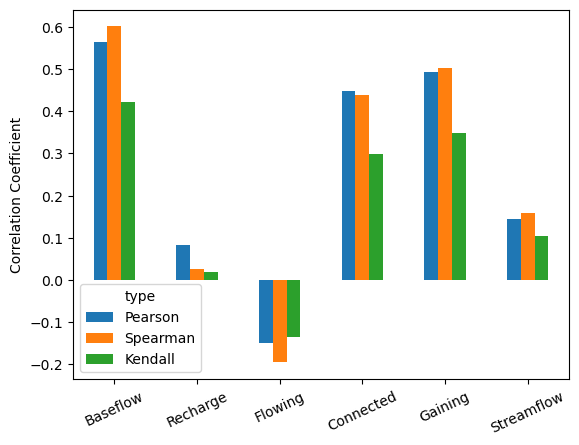

In [692]:
fig, ax = plt.subplots()
# prepare for plotting
corr_out = corr_out.loc['r'].set_index('type').transpose()

corr_out.plot(kind='bar', ax=ax, rot=25)
# fix column names
ax.set_xticks(ticks = np.arange(0,corr_all.shape[1]), labels = [variables[v] for v in corr_all.columns.values])
plt.ylabel('Correlation Coefficient')
# ax.xticks

## Correlations grouped by water year
|WY |Types|WYsum|
|:----|:---------------|-----|
|2015 | Critical|9.23|
|2016 | Below Normal|17.47|
|2017 | Wet|37.82|
|2018 | Below Normal|12.86|

In [694]:
# yearly
# the data is already summed across the year and should be averaged across segments
corr_bool = sfr_yr_sum_all.groupby(['realization', 'WY']).mean()
corr_bool = corr_bool[['flowing','connected','gaining']]
# seepage data just needs to be summed again 
corr_seep = sfr_yr_sum_all.groupby(['realization', 'WY']).sum(numeric_only=True)[['Qbase','Qrech']]
# flow data should be averaged
corr_flow = sfr_last_all.groupby(['realization','WY']).mean(numeric_only=True)[['Qout']]
# join together the data for correlations
corr_all = corr_seep.join(corr_bool).join(corr_flow).reset_index('WY')

In [695]:
corr_out = pd.DataFrame()
for n_wy in wy_vals:
# corr_all.groupby('WY').apply(lambda x : pearsonr(coarse_ref.num_coarse, x))
    corr_wy = corr_all[corr_all.WY==n_wy].drop(columns=['WY'])
    corr_out = pd.concat((corr_out, calc_corr_stats(corr_wy).assign(WY=n_wy)))
    

In [696]:
# the applicability of certain variables is questionable since Qrech, flowing, Qout have median
# p values of > 0.05
corr_out.loc['p']

,Qbase,Qrech,flowing,connected,gaining,Qout,type,WY
p,4.878014e-07,0.712999,0.497079,1.376338e-06,1.105344e-05,0.532556,Pearson,2015
p,6.109690e-09,0.283457,0.229566,8.302698e-07,1.463337e-06,0.188135,Spearman,2015
p,2.974436e-08,0.271494,0.206393,2.252960e-06,2.927594e-06,0.171365,Kendall,2015
p,3.049656e-07,0.387604,0.022339,8.748797e-07,5.942877e-07,0.116880,Pearson,2016
p,4.498398e-10,0.779765,0.007322,1.334860e-06,5.983000e-08,0.087576,Spearman,2016
p,3.967349e-09,0.740809,0.007718,4.915130e-06,2.299392e-07,0.085528,Kendall,2016
p,1.687573e-10,0.187896,0.024068,4.962723e-06,8.779803e-07,0.095496,Pearson,2017
p,3.880790e-11,0.498964,0.007523,3.932927e-06,1.014811e-06,0.076106,Spearman,2017
p,7.287771e-10,0.461690,0.006452,1.017519e-05,3.800242e-06,0.078205,Kendall,2017
p,3.272379e-09,0.200469,0.392695,2.532024e-04,9.638305e-08,0.176224,Pearson,2018


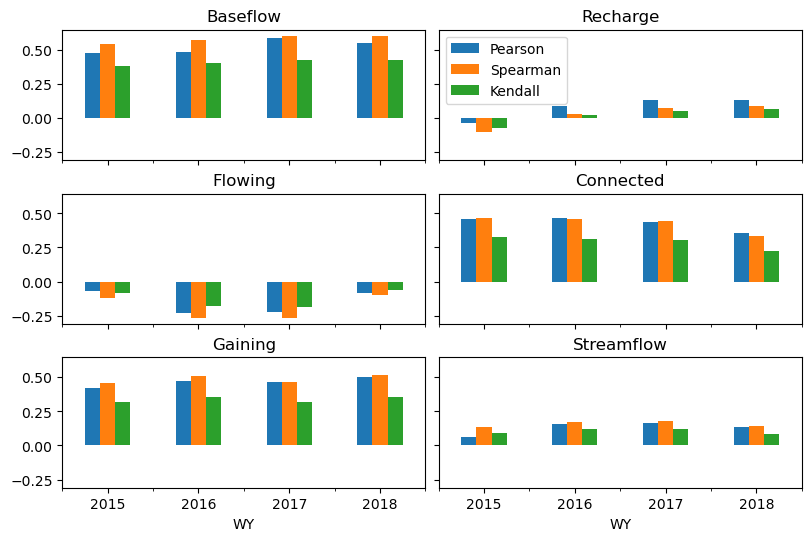

In [552]:
fig, ax = plt.subplots(3,2, figsize=(8,5.3), sharex=True, sharey=True, layout='constrained')
for n, v in enumerate(variables.keys()):
    ax_n = ax[int(n/2), n%2]
    corr_plt = corr_out.loc['r'][[v,'type','WY']].pivot_table(index='WY', values=v, columns='type')
    # correct order of tests which were resorted
    corr_plt[tests].plot(kind='bar', ax=ax_n, legend=False, rot=0)
    ax_n.set_title(variables[v])
ax[0,1].legend(loc='best')


## Correlations grouped by season and year

In [753]:
# yearly
# the data is already summed across the year and should be averaged across segments
corr_bool = sfr_3mon_all.copy().set_index('realization',append=True)[['flowing','connected','gaining']]
# sum across all segments for seepage
corr_seep = sfr_facies_all.groupby('realization').resample('3MS').sum(numeric_only=True)[['Qbase','Qrech']]
# flow data should be averaged
corr_flow = sfr_last_all.groupby(['realization']).resample('3MS').mean(numeric_only=True)[['Qout']]
# join together the data for correlations
corr_all = corr_seep.join(corr_bool).join(corr_flow).reset_index('dt')

In [754]:
corr_out = pd.DataFrame()
for n_dt in corr_all.dt.unique():
# corr_all.groupby('WY').apply(lambda x : pearsonr(coarse_ref.num_coarse, x))
    corr_dt = corr_all[corr_all.dt==n_dt].drop(columns=['dt'])
    corr_out = pd.concat((corr_out, calc_corr_stats(corr_dt).assign(dt=n_dt)))
corr_out['month'] = corr_out.dt.dt.month
corr_out['wy'] = corr_out.dt.dt.year
corr_out.loc[corr_out.month==10,'wy'] +=1
corr_out = corr_out.drop(columns=['dt'])   

In [755]:
# there are NA values prodcued in some cases during the winter, only for flowing variable
# the NAs occur because in 2016 every realization had 100% of days in winter,spring with flow so there is
# no relationship at all

In [775]:
# the applicability of certain variables is questionable since Qrech, flowing, Qout have median
# p values of > 0.05
# corr_out.loc['p']

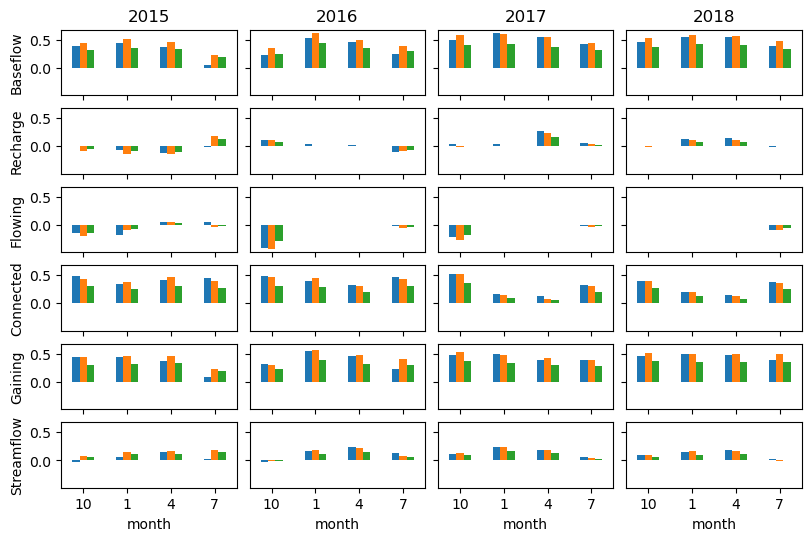

In [630]:
fig, ax = plt.subplots(6,4, figsize=(8,5.3), sharex=True, sharey=True, layout='constrained')
for nv, v in enumerate(variables.keys()): #['Qbase','Qout']
    corr_plt = corr_out.loc['r'][[v,'type','wy','month']] 
    for nwy, wy in enumerate(corr_plt.wy.unique()):
        ax_n = ax[nv, nwy]
        corr_wy = corr_plt[corr_plt.wy==wy].drop(columns=['wy']).pivot_table(index='month', values=v, 
                                                                             columns='type', dropna=False)
        # correct order of tests and months to fix sorting
        corr_wy[tests].loc[corr_out.month.unique()].plot(kind='bar', ax=ax_n, legend=False, rot=0)
        ax_n.set_ylabel(variables[v])
for nwy, wy in enumerate(corr_plt.wy.unique()):
    ax_n = ax[0, nwy]
    ax_n.set_title(wy)
#     ax_n.set_xticks(ticks = np.arange(0,corr_mon.shape[0]), labels = corr_out.month.unique())


# ax[0,1].legend(loc='best')


### Questions on correlations
How did you find these three correlative statistics?
I noticed you adjusted for normallity for Pearson's r with the variable and predictor? Was that determined by looking at the distribution of the variable for the 100 sites? In my case I have 100 realizations
How did you find the actual value of the statistic relevant? I'm considering primarily looking at the comparison between statistics to show where correlation is stronger?

Pearson's r requires normality, Steve applied log10 transformation selectively on variables and predictors to improve normality. Spearman's rho and Kendall's tau. In this case the variable is the number of coarse stream segments, the histogram shows it sort of normally distributed with a slight peak around 30, but the data has lots of highs and lows probably because I'm plotting the number of segments with coarse and not necessarily the number of coarse bodies connecting to the stream.

array([[<Axes: title={'center': 'num_coarse'}>]], dtype=object)

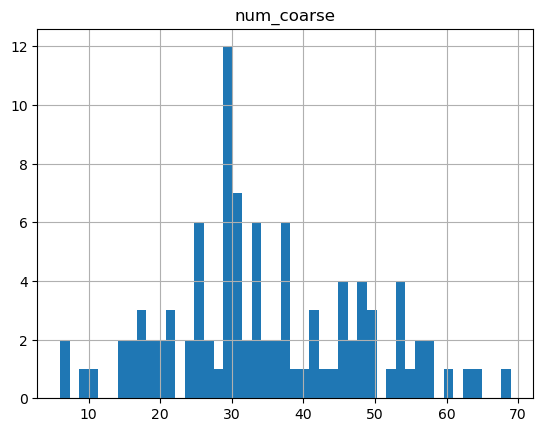

In [83]:
bins = len(sfr_3mon_all.groupby('realization').mean(numeric_only=True).num_coarse.unique())
sfr_3mon_all.groupby('realization').mean(numeric_only=True).hist('num_coarse', bins = bins)

Text(0.85, 0.85, '$r^2$: 0.354')

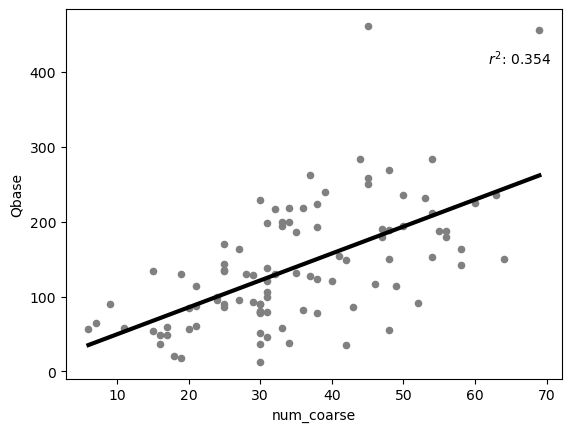

In [110]:
# exampel regression
plt_month = sfr_3mon_all[sfr_3mon_all.month==1]
df_plt = plt_month[plt_month.WY==2017]
ax = df_plt.plot(x='num_coarse',y='Qbase', kind='scatter', color='gray')

regr = linear_model.LinearRegression()
regr.fit(df_plt[['num_coarse']].values, df_plt[['Qbase']].values)
x_range = np.array([[df_plt.num_coarse.min()], [df_plt.num_coarse.max()]])
ax.plot(x_range, regr.predict(x_range), color='black', linewidth=3)
r2_val = r2_score(df_plt[['Qbase']], regr.predict(df_plt[['num_coarse']].values))
ax.annotate('$r^2$: '+ str(np.round(r2_val,3)), (0.85,0.85), xycoords='axes fraction')

In [709]:
def corr_plt_seep(name, ylabel):
    """ name is Qbase or Qrech"""
    fig,ax = plt.subplots(4,4, figsize=(8,5.3), sharex=True, sharey=False, layout='constrained')
    # plot of number of connected days across realizations
    # plot across years in rows
    for yn, wy in enumerate(plt_month.WY.unique()):
        df_wy = sfr_3mon_all[sfr_3mon_all.WY==wy]
        # plot across 3 month blocks in columns
        for mn, mon in enumerate(sfrdf_all.month.unique()):
            df_plt = df_wy[df_wy.month==mon]
            ax_n = ax[yn, mn]
            df_plt.plot(x='num_coarse',y=name, kind='scatter', color='gray', ax = ax_n)
            # linear, regression
#             sns.regplot(x='num_coarse', y=name,data=df_plt,ci=False,ax=ax_n, label='Linear Model', scatter=False)
            regr = linear_model.LinearRegression()
            regr.fit(df_plt[['num_coarse']].values, df_plt[[name]].values)
            x_range = np.array([[df_plt.num_coarse.min()], [df_plt.num_coarse.max()]])
            ax_n.plot(x_range, regr.predict(x_range), color='black', linewidth=3)
            r2_val = r2_score(df_plt[[name]], regr.predict(df_plt[['num_coarse']].values))
            ax_n.annotate('$r^2$: '+ str(np.round(r2_val,3)), (0.1,0.8), xycoords='axes fraction')
            # plot clean up
            ax_n.set_ylabel('')
            ax_n.set_xlabel('')

    for yn, wy in enumerate(plt_month.WY.unique().astype(int)):
        ax_n = ax[yn, 0]
        ax_n.set_ylabel(str(wy))
    labels_3mon = ['Oct-Dec','Jan-Mar','Apr-Jun','Jul-Sep']
    for mn, mon in enumerate(sfrdf_all.month.unique()):
        ax_n = ax[0, mn]
        ax_n.set_title(labels_3mon[mn])
    fig.text(-0.01, 0.4, 'Mean Seasonal '+ylabel, rotation=90)
    fig.text(0.4, -0.01, 'Number of Coarse Stream Segments')

    fig.tight_layout()

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_100216\3244055794.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


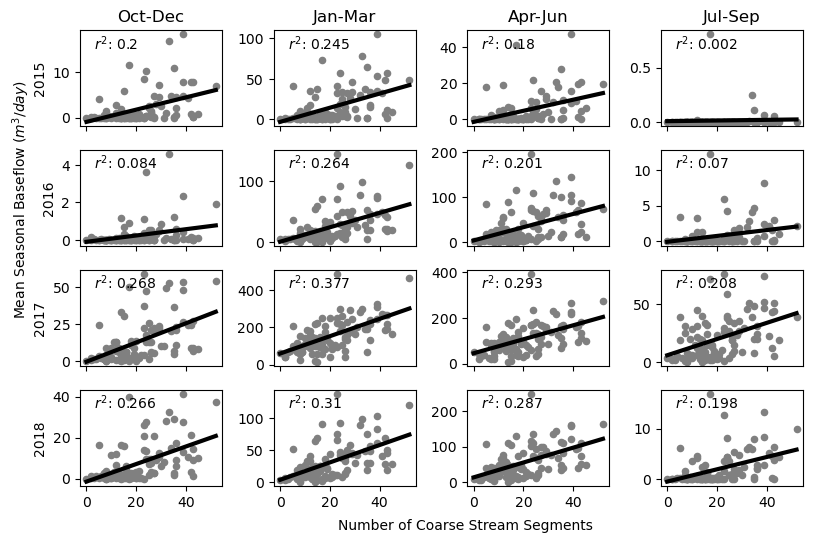

In [710]:
corr_plt_seep('Qbase', 'Baseflow ($m^3/day$)')

# Application figure
Summary of net change in baseflow and ET for all realizations compared to the homogeneous case.

And importantly, how does this change baseflow in seasons of concern, regarding the cosumnes functional flow regime. Between the homogeneous and hetergeneous realizations we need to sum across all segments because it's not fair to compare individual segments with the heterogeneity. But each day is a valuable comparison because a lack of flow is potential harmful to up-migrating salmon especially in fall.

Although the number of days with flow doesn't have a significant relationship with heterogeneity I can still present the results holistically.

In [739]:
# sfr_facies_all
# sum for the seepage
total_flow = sfr_facies_all.groupby('realization').resample('3MS').sum(numeric_only=True)[['Qbase']]
total_flow = total_flow.reset_index('realization')

# homogeneous case
h_flow = h_sfrdf.resample('3MS').sum(numeric_only=True)[['Qbase']]
h_conn = h_sfrdf.resample('3MS').mean(numeric_only=True)[['flowing']]

In [799]:
nseg = sfrdf.segment.unique().shape[0]
# average for days of connection (facies are already summed so sum together then divide by number of segments)
# now it is the fraction of the segments with flow
total_conn = sfr_facies_all.groupby(['realization', 'dt']).sum(numeric_only=True)[['flowing']]/nseg
total_conn = total_conn.reset_index('realization')
# can calculate the fraction of a season with flow
total_conn = total_conn.groupby('realization').resample('3MS').mean().reset_index('realization', drop=True)

Similar to the plot showing days with flow by segment, the overall number of days with flow doesn't change much when looking at the histogram. From the earlier plots it looked like flow was extended at the downstream longer while reduced at the upstream. To show how downstream conditions change, we should represent the flow by requiring all segments to be flowing, take minimum of all segments which would essentially be the same as taking the most downstream segment. 

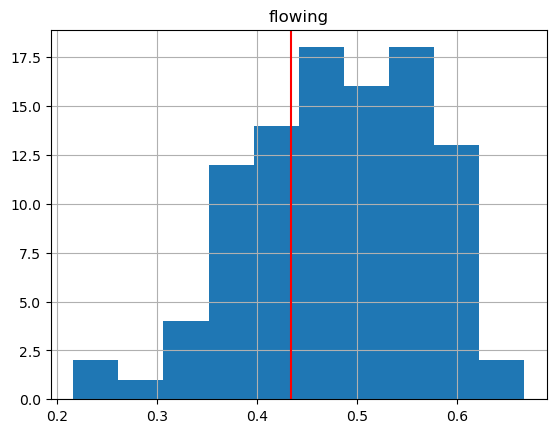

In [824]:
plt_date = '2015-10-1'
total_conn[total_conn.index==plt_date].hist('flowing')
plt.axvline(h_conn[h_conn.index==plt_date].flowing[0],color='red')

#plot(x='realization',y='flowing',kind='scatter')

In [744]:
total_flow = total_flow.join(h_flow,rsuffix='_h')
total_flow['Qbase_diff'] = total_flow.Qbase - total_flow.Qbase_h

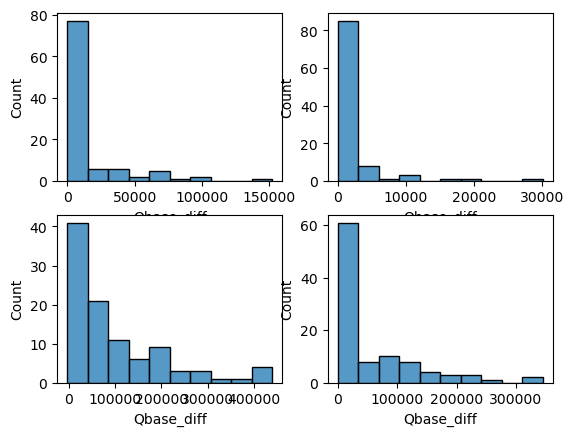

In [750]:
total_flow_fall = total_flow[total_flow.index.month==10]
fig, ax = plt.subplots(2,2)
for n, y in enumerate(total_flow_fall.index.unique()):
    ax_n = ax[int(n/2), n%2]
    sns.histplot(total_flow_fall[total_flow_fall.index==y], x='Qbase_diff', ax=ax_n,bins=10)

## Last segment comparison
Show plot of how the number of days of flow averaged doesn't change much from the homogeneous case, but the days with flow at the outlet are more noticeable.

In [851]:
# groupby season and year
total_last = sfr_last_all.groupby('realization', group_keys=False).resample('3MS').mean(numeric_only=True)
h_last = h_sfrdf[h_sfrdf.segment==h_sfrdf.segment.max()]
h_last = h_last.resample('3MS').mean(numeric_only=True)


In [841]:
total_last.columns

Index(['layer', 'row', 'column', 'segment', 'reach', 'Qin', 'Qaquifer', 'Qout',
       'Qovr', 'Qprecip', 'Qet', 'stage', 'depth', 'width', 'Cond', 'gradient',
       'strtop_all', 'k', 'i', 'j', 'rchlen', 'strtop', 'Total distance (m)',
       'num_coarse', 'month', 'WY', 'flowing', 'Qin_cfs', 'Qout_cfs',
       'Qaquifer_cfs', 'Qrech', 'Qbase', 'gaining', 'losing', 'connected',
       'realization'],
      dtype='object')

In [845]:
# we want to give something easy to digest so like a yes or no, or the number of realizations each season
# that are better than the homogeneous case
# total_last['month'] = total_last.index.get_level_values('dt').month
# total_last.groupby(['realization','month']).mean()

In [860]:
# total_[['Qout']]

In [879]:
# calculate difference in flow from base case
total_last['Qout_diff'] = (total_last[['Qout']] - h_last[['Qout']]).values
total_last['flowing_diff'] = (total_last[['flowing']] - h_last[['flowing']]).values
# get values for fall only
total_last_fall = total_last[total_last.index.month==10]


Does it make sense to give a simple response such as this many realization provided more water or the volume difference average.

In [888]:
for n, n_y in enumerate(total_last_fall.index.year.unique()):
    more_flow = (total_last_fall[total_last_fall.index.year==n_y].flowing_diff>=0)
    more_flow = (total_last_fall[total_last_fall.index.year==n_y].Qout_diff>=0)

    print(n_y+1, more_flow.sum())

2015 99
2016 99
2017 95
2018 97


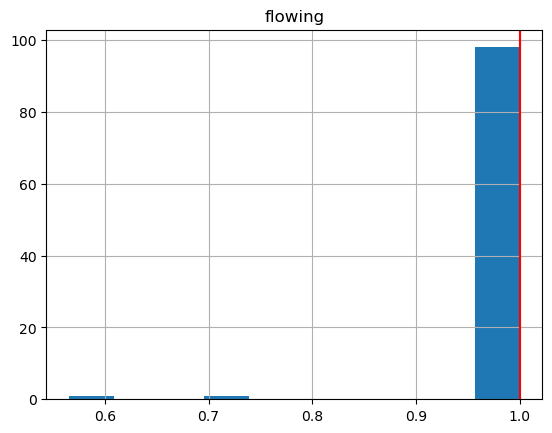

In [883]:
plt_date = '2017-10-1'

total_last[total_conn.index==plt_date].hist('flowing')
plt.axvline(h_last[h_conn.index==plt_date].flowing[0],color='red')
